We are going to gather the Posterior Predictive distribution of the variables related to the flux and then plot them

In [1]:
from pathlib import Path

from maudy.analysis import load, predict, summary

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
var_names = (
    "unb_conc",
    "ln_bal_conc",
    "ln_bal_conc",
    "flux",
    "ci",
    "vmax",
    "sat",
    "free_enzyme_ratio",
    "rev",
    "ssd",
)

In [3]:
linear_output = Path("../results/linear_actual_vae")

In [4]:
example_ode_output = Path("../results/example_ode_actual_vae")

In [5]:
assert linear_output.exists()
assert example_ode_output.exists()

Running the model forward should not take longer than 30s (depending on the number of reactions and the neural network arch).

In [6]:
maudy, _ = load(linear_output)
samples = predict(maudy, 1000, var_names=var_names)

/home/georg/git/maudy/maudy/model.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.dgf_means = torch.Tensor(


Wrangle some of the shapes that are gathered wrong somehow.

In [7]:
for var_name in var_names:
    if samples[var_name].shape[1] == 1:
        samples[var_name] = samples[var_name].squeeze(1)

In [8]:
samples["sat"].shape

torch.Size([1000, 2, 3])

Set up the index axes.

In [9]:
kcat_pars = maudy.maud_params.kcat.prior
enzymatic_reactions = [x.split("_")[-1] for x in kcat_pars.ids[-1]]
balanced_mics = [met.id for met in maudy.kinetic_model.mics if met.balanced]
unbalanced_mics = [met.id for met in maudy.kinetic_model.mics if not met.balanced]

Gather some summary stats

In [10]:
import pandas as pd

In [11]:
{key: val.shape for key, val in samples.items()}

{'unb_conc': torch.Size([1000, 2, 2]),
 'ln_bal_conc': torch.Size([1000, 2, 2]),
 'ci': torch.Size([1000, 2, 3]),
 'free_enzyme_ratio': torch.Size([1000, 2, 3]),
 'vmax': torch.Size([1000, 2, 3]),
 'rev': torch.Size([1000, 2, 3]),
 'sat': torch.Size([1000, 2, 3]),
 'flux': torch.Size([1000, 2, 3]),
 'ssd': torch.Size([1000, 2, 2])}

In [12]:
pred_summary = summary(samples)
across_exps = {var_name: [] for var_name in var_names}
for i, experiment in enumerate(maudy.experiments):
    for var_name in across_exps.keys():
        this_samples = samples[var_name]
        df = pd.DataFrame(
            [this_samples[:, i, idx].tolist() for idx in range(this_samples.shape[-1])],
            index=unbalanced_mics
            if "unb" in var_name
            else balanced_mics
            if "bal_conc" in var_name or "ssd" in var_name
            else enzymatic_reactions,
        ).T
        df["experiment"] = experiment
        across_exps[var_name].append(df)

In [13]:
flux_output = []
for var_name, dfs in across_exps.items():
    if "conc" not in var_name and "ssd" not in var_name:
        for df in dfs:
            df["module"] = var_name
        flux_output.append(pd.concat(dfs))
flux_df = pd.concat(flux_output)

Finally, some plots.

In [14]:
from plotnine import *

In [15]:
flux_df.head()

,r1,r2,r3,experiment,module
0,-0.000101,0.010623,0.060947,condition1,flux
1,-0.265303,0.008708,0.062893,condition1,flux
2,-0.224631,0.204837,0.010773,condition1,flux
3,-0.064612,0.009502,0.095978,condition1,flux
4,0.459848,0.008242,0.353916,condition1,flux


In [16]:
flux_df = flux_df.melt(id_vars=["experiment", "module"], var_name="reaction")

In [17]:
flux_df.dtypes

experiment     object
module         object
reaction       object
value         float64
dtype: object

In [18]:
import numpy as np

In [19]:
from maud.getting_idatas import MeasurementType

reac_measurements = {
    (exp.id, f"{meas.reaction}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.FLUX
}
reac_meas = [list(keys) + list(val) for keys, val in reac_measurements.items()]
reac_meas = pd.DataFrame(reac_meas, columns=["experiment", "reaction", "loc", "std"])
reac_meas["up"] = reac_meas["loc"] + 1.96 * reac_meas["std"]
reac_meas["down"] = reac_meas["loc"] - 1.96 * reac_meas["std"]
reac_meas["kind"] = "observed"
reac_meas["value"] = reac_meas["loc"]

flux_df["kind"] = "sampled"

reac_meas["module"] = "flux"

reac_meas["kind"] = "observed"

In [20]:
flux_df["module"] = flux_df["module"].str.replace("free_enzyme_ratio", "enz. ratio")

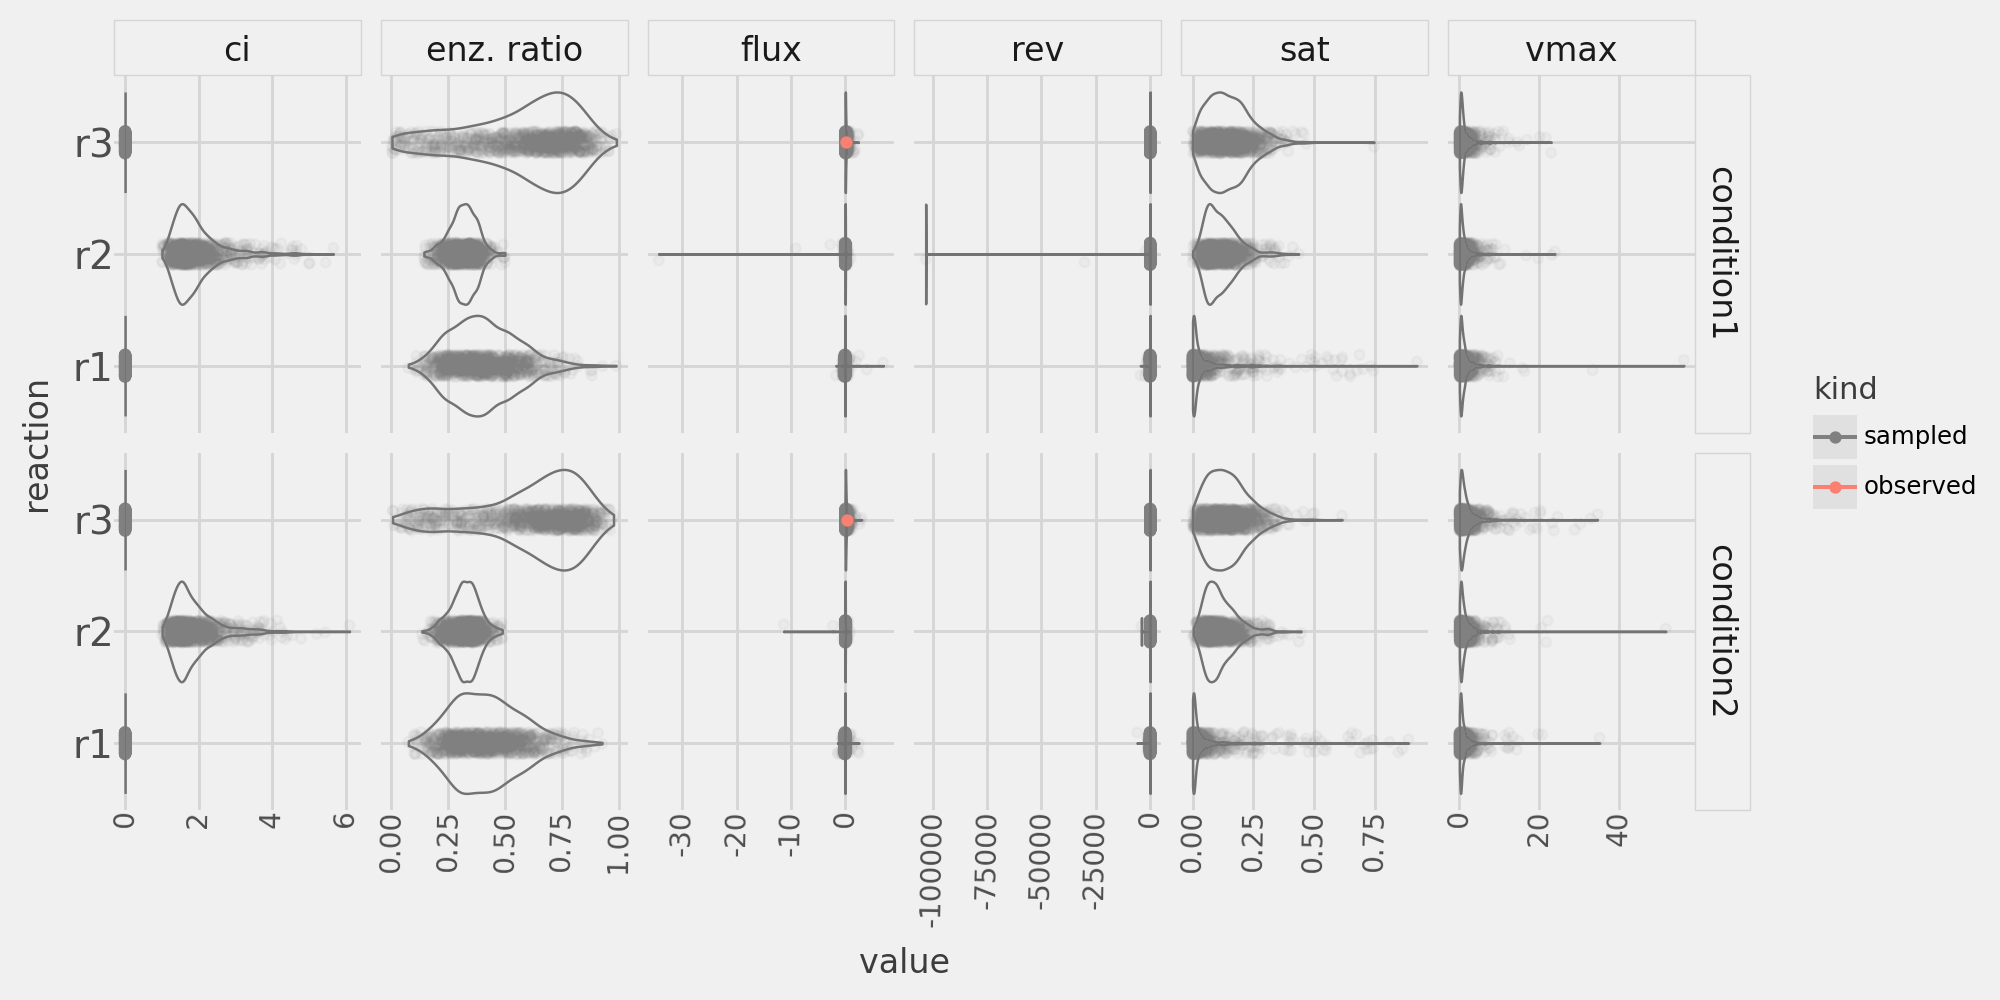

In [21]:
linear_flux_plot = (
    ggplot(
        flux_df,
        aes(
            x="reaction",
            y="value",
            color="kind",
        ),
    )
    + geom_violin(scale="width", fill="none", color="#757275")
    + geom_jitter(alpha=0.05, width=0.1, height=0.00001)
    + geom_point(data=reac_meas)
    + geom_linerange(mapping=aes(ymin="down", ymax="up"), data=reac_meas)
    + coord_flip()
    + facet_grid("experiment ~ module", scales="free_x")
    + theme_538()
    #+ theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(figure_size=(10, 5),
           strip_text=element_text(size=12),
        axis_text_x=element_text(size=10, rotation=89),
        axis_text_y=element_text(size=14),
        axis_title=element_text(size=12), strip_background=element_rect(fill="#f0f0f0", color="#d5d5d5", size=0.5, ))
    + scale_color_manual(["gray", "salmon"])
)
linear_flux_plot

In [22]:
conc_output = []
for var_name, dfs in across_exps.items():
    if "conc" in var_name:
        for df in dfs:
            df["kind"] = var_name
        conc_output.append(pd.concat(dfs))
conc_df = pd.concat(conc_output)

In [23]:
conc_df = conc_df.melt(id_vars=["experiment", "kind"], var_name="metabolite")

In [24]:
conc_df

,experiment,kind,metabolite,value
0,condition1,unb_conc,M1_e,0.614653
1,condition1,unb_conc,M1_e,0.209349
2,condition1,unb_conc,M1_e,0.011321
3,condition1,unb_conc,M1_e,0.034464
4,condition1,unb_conc,M1_e,7.489513
...,...,...,...,...
15995,condition2,ln_bal_conc,M2_c,-1.088883
15996,condition2,ln_bal_conc,M2_c,-1.217218
15997,condition2,ln_bal_conc,M2_c,-0.721807
15998,condition2,ln_bal_conc,M2_c,-0.382736


In [25]:
conc_df.loc[conc_df.kind == "ln_bal_conc", "value"] = np.exp(conc_df.loc[conc_df.kind == "ln_bal_conc", "value"])

In [26]:
from maud.getting_idatas import MeasurementType

mics_measurements = {
    (exp.id, f"{meas.metabolite}_{meas.compartment}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.MIC
}
conc_meas = [list(keys) + list(val) for keys, val in mics_measurements.items()]
conc_meas = pd.DataFrame(conc_meas, columns=["experiment", "metabolite", "exploc", "scale"])
conc_meas["up"] = np.exp(np.log(conc_meas["exploc"]) + 1.96*conc_meas["scale"])
conc_meas["down"] = np.exp(np.log(conc_meas["exploc"]) - 1.96*conc_meas["scale"])
conc_meas["kind"] = "observed"
conc_meas["value"] = conc_meas["exploc"]

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.


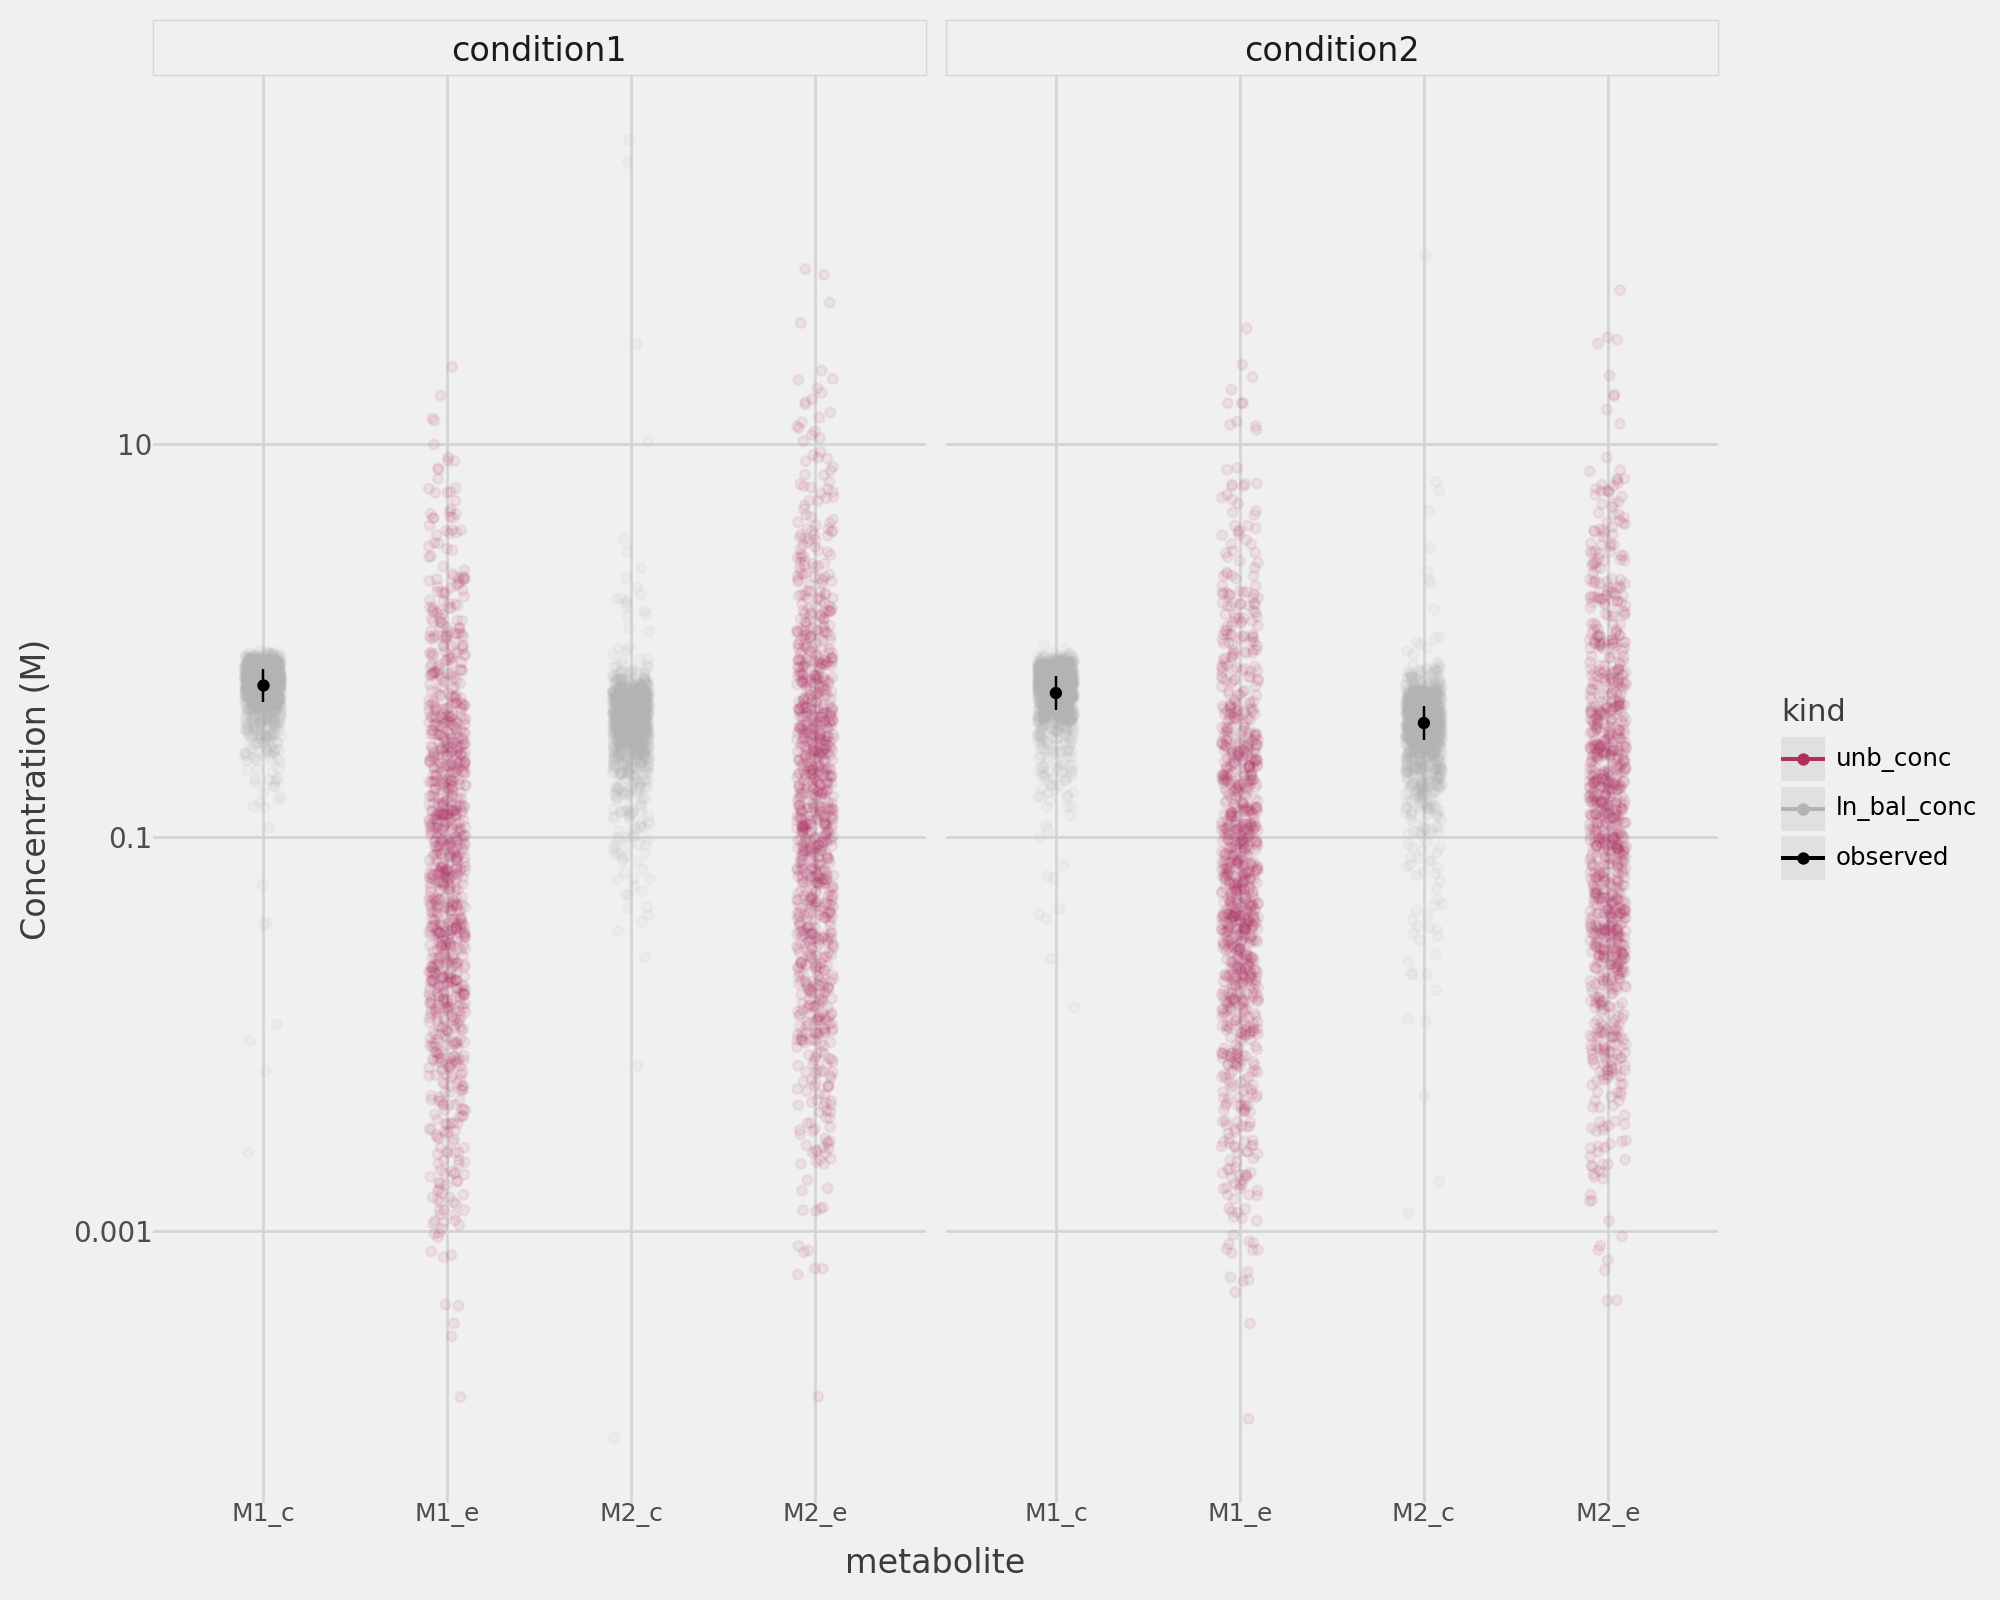

In [27]:
linear_plot = (
    ggplot(
        conc_df,
        aes(
            x="metabolite",
            y="value",
            #color="kind",
            color="kind",
        ),
    )
    + geom_jitter(data=conc_df[conc_df.kind != "ln_bal_conc"], alpha=0.08, width=0.1, height=0)
    + geom_jitter(data=conc_df[conc_df.kind == "ln_bal_conc"], alpha=0.08, width=0.1, height=0)
    + geom_linerange(data=conc_meas, mapping=aes(ymin="down", ymax="up"))
    + geom_point(data=conc_meas)
    + scale_y_log10()
    + theme_538()
    + facet_wrap("~ experiment", ncol=2)
    #+ theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(figure_size=(10, 8),
           strip_text=element_text(size=12),
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=9),
        axis_title=element_text(size=12), strip_background=element_rect(fill="#f0f0f0", color="#d5d5d5", size=0.5, ))
    #+ scale_color_manual(["gray", "red", "black"])
    + scale_color_manual(["#af2f5f", "#b3b3b3", "black"])
    + ylab("Concentration (M)")
)
linear_plot

This is the (model) ssd for a run trained with half the samples.

In [28]:
ssd = pd.concat(across_exps["ssd"])

In [29]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np


def pairplot(df: pd.DataFrame, figsize=(5,5)):
    num_exps = len(pd.unique(df.experiment))
    # Create the figure and axes matrix
    columns = [col for col in df.columns if col != "experiment"]
    fig, axes = plt.subplots(len(columns), len(columns), figsize=figsize)

    # Mapping of column index to DataFrame columns
    possible_colours = ["#fdbf6f",  "#af2f5f","black", "#b3b3b3"] if num_exps > 1 else ["#75757c"]
    print(possible_colours)
    
    colors = defaultdict(lambda: possible_colours.pop())
    background_color = '#f0f0f0'
    text_color = '#353535'
    fig.patch.set_facecolor(background_color)  # Set the background color for the figure


    for i in range(len(columns)):
        for j in range(len(columns)):
            ax = axes[i, j]
            ax.set_facecolor(background_color)
            ax.set_frame_on(False)  # Remove background frame for each subplot
            for label in (ax.get_xticklabels() + ax.get_yticklabels() + [ax.title, ax.xaxis.label, ax.yaxis.label]):
                label.set_color(text_color)  
            if i == j:  # Diagonal: histograms, colored by experiment
                for experiment in df['experiment'].unique():
                    subset = df[df['experiment'] == experiment]
                    ax.hist(subset[columns[i]], color=colors[experiment], bins=20, alpha=0.7, label=f'{experiment}')
            else:  # Off-diagonal: scatter plots
                for experiment in df['experiment'].unique():
                    subset = df[df['experiment'] == experiment]
                    ax.scatter(subset[columns[j]], subset[columns[i]], color=colors[experiment], label=f'{experiment}', s=10)  # Smaller points

            # Labels
            if i == len(columns) - 1:
                ax.set_xlabel(f"{columns[j]} Steady Dev.", fontsize=10)
            if j == 0:
                ax.set_ylabel(columns[i], fontsize=10)
            if i == len(columns) - 1 and j == len(columns) - 1 and num_exps > 1:
                ax.legend(frameon=False) 

            # Reduce axis lines to minimal
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if i != len(columns) - 1:  # Remove x-axis labels and ticks for upper plots
                ax.xaxis.set_visible(False)
    fig.tight_layout()
    return fig

['#fdbf6f', '#af2f5f', 'black', '#b3b3b3']


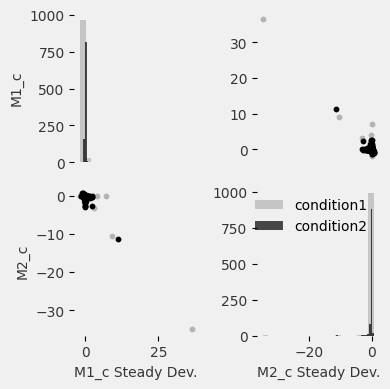

In [30]:
l_ssd_plot = pairplot(ssd, (4, 4))
l_ssd_plot

So the model with the positive term is clearly the right one.

Running the model forward should not take longer than 30s (depending on the number of reactions and the neural network arch).

In [31]:
import pyro

In [32]:
pyro.clear_param_store()

In [33]:
maudy, _ = load(example_ode_output)
samples = predict(maudy, 1000, var_names=var_names)

/home/georg/git/maudy/maudy/model.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Wrangle some of the shapes that are gathered wrong somehow.

In [34]:
for var_name in var_names:
    if samples[var_name].shape[1] == 1 and len(samples[var_name].shape) == 4:
        samples[var_name] = samples[var_name].squeeze(1)

In [35]:
samples["sat"].shape

torch.Size([1000, 1, 4])

Set up the index axes.

In [36]:
kcat_pars = maudy.maud_params.kcat.prior
enzymatic_reactions = [x.split("_")[-1] for x in kcat_pars.ids[-1]]
balanced_mics = [met.id for met in maudy.kinetic_model.mics if met.balanced]
unbalanced_mics = [met.id for met in maudy.kinetic_model.mics if not met.balanced]

Gather some summary stats

In [37]:
import pandas as pd

In [38]:
{key: val.shape for key, val in samples.items()}

{'unb_conc': torch.Size([1000, 1, 2]),
 'ln_bal_conc': torch.Size([1000, 1, 2]),
 'ci': torch.Size([1000, 1, 4]),
 'free_enzyme_ratio': torch.Size([1000, 1, 4]),
 'vmax': torch.Size([1000, 1, 4]),
 'rev': torch.Size([1000, 1, 4]),
 'sat': torch.Size([1000, 1, 4]),
 'flux': torch.Size([1000, 1, 4]),
 'ssd': torch.Size([1000, 1, 2])}

In [39]:
pred_summary["flux"]

{'mean': tensor([[-0.0160, -0.0137,  0.1558],
         [-0.0136,  0.0298,  0.2074]]),
 'std': tensor([[0.3081, 1.1308, 0.2185],
         [0.2043, 0.3740, 0.2746]]),
 '5%': tensor([[-0.1997,  0.0011,  0.0092],
         [-0.1589,  0.0019,  0.0141]]),
 '95%': tensor([[0.1064, 0.1283, 0.4981],
         [0.0898, 0.1560, 0.6418]])}

In [40]:
pred_summary = summary(samples)
across_exps = {var_name: [] for var_name in var_names}
for i, experiment in enumerate(maudy.experiments):
    for var_name in across_exps.keys():
        this_samples = samples[var_name]
        df = pd.DataFrame(
            [this_samples[:, i, idx].tolist() for idx in range(this_samples.shape[-1])],
            index=unbalanced_mics
            if "unb" in var_name
            else balanced_mics
            if "bal_conc" in var_name or "ssd" in var_name
            else enzymatic_reactions,
        ).T
        df["experiment"] = experiment
        across_exps[var_name].append(df)

In [41]:
flux_output = []
for var_name, dfs in across_exps.items():
    if "conc" not in var_name and "ssd" not in var_name:
        for df in dfs:
            df["module"] = var_name
        flux_output.append(pd.concat(dfs))
flux_df = pd.concat(flux_output)

Finally, some plots.

In [42]:
flux_df.head()

,r1,r2,r3,r4,experiment,module
0,0.217650,1.794137,0.638422,2.190961,condition1,flux
1,0.354188,1.115434,0.828417,2.882421,condition1,flux
2,0.257826,2.394278,0.329194,1.401257,condition1,flux
3,0.425918,2.372474,0.183937,2.953315,condition1,flux
4,0.230880,1.824771,0.193639,2.393188,condition1,flux


In [43]:
flux_df = flux_df.melt(id_vars=["experiment", "module"], var_name="reaction")

In [44]:
import numpy as np

In [45]:
from maud.getting_idatas import MeasurementType

reac_measurements = {
    (exp.id, f"{meas.reaction}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.FLUX
}
reac_meas = [list(keys) + list(val) for keys, val in reac_measurements.items()]
reac_meas = pd.DataFrame(reac_meas, columns=["experiment", "reaction", "loc", "std"])
reac_meas["up"] = reac_meas["loc"] + 1.96 * reac_meas["std"]
reac_meas["down"] = reac_meas["loc"] - 1.96 * reac_meas["std"]
reac_meas["kind"] = "observed"
reac_meas["value"] = reac_meas["loc"]

flux_df["kind"] = "sampled"

reac_meas["module"] = "flux"

reac_meas["kind"] = "observed"

In [46]:
flux_df["module"] = flux_df["module"].str.replace("free_enzyme_ratio", "enz. ratio")

In [47]:
reac_meas

,experiment,reaction,loc,std,up,down,kind,value,module
0,condition1,r3,0.421816,0.01,0.441416,0.402216,observed,0.421816,flux
1,condition1,r4,2.116740,0.01,2.136340,2.097140,observed,2.116740,flux


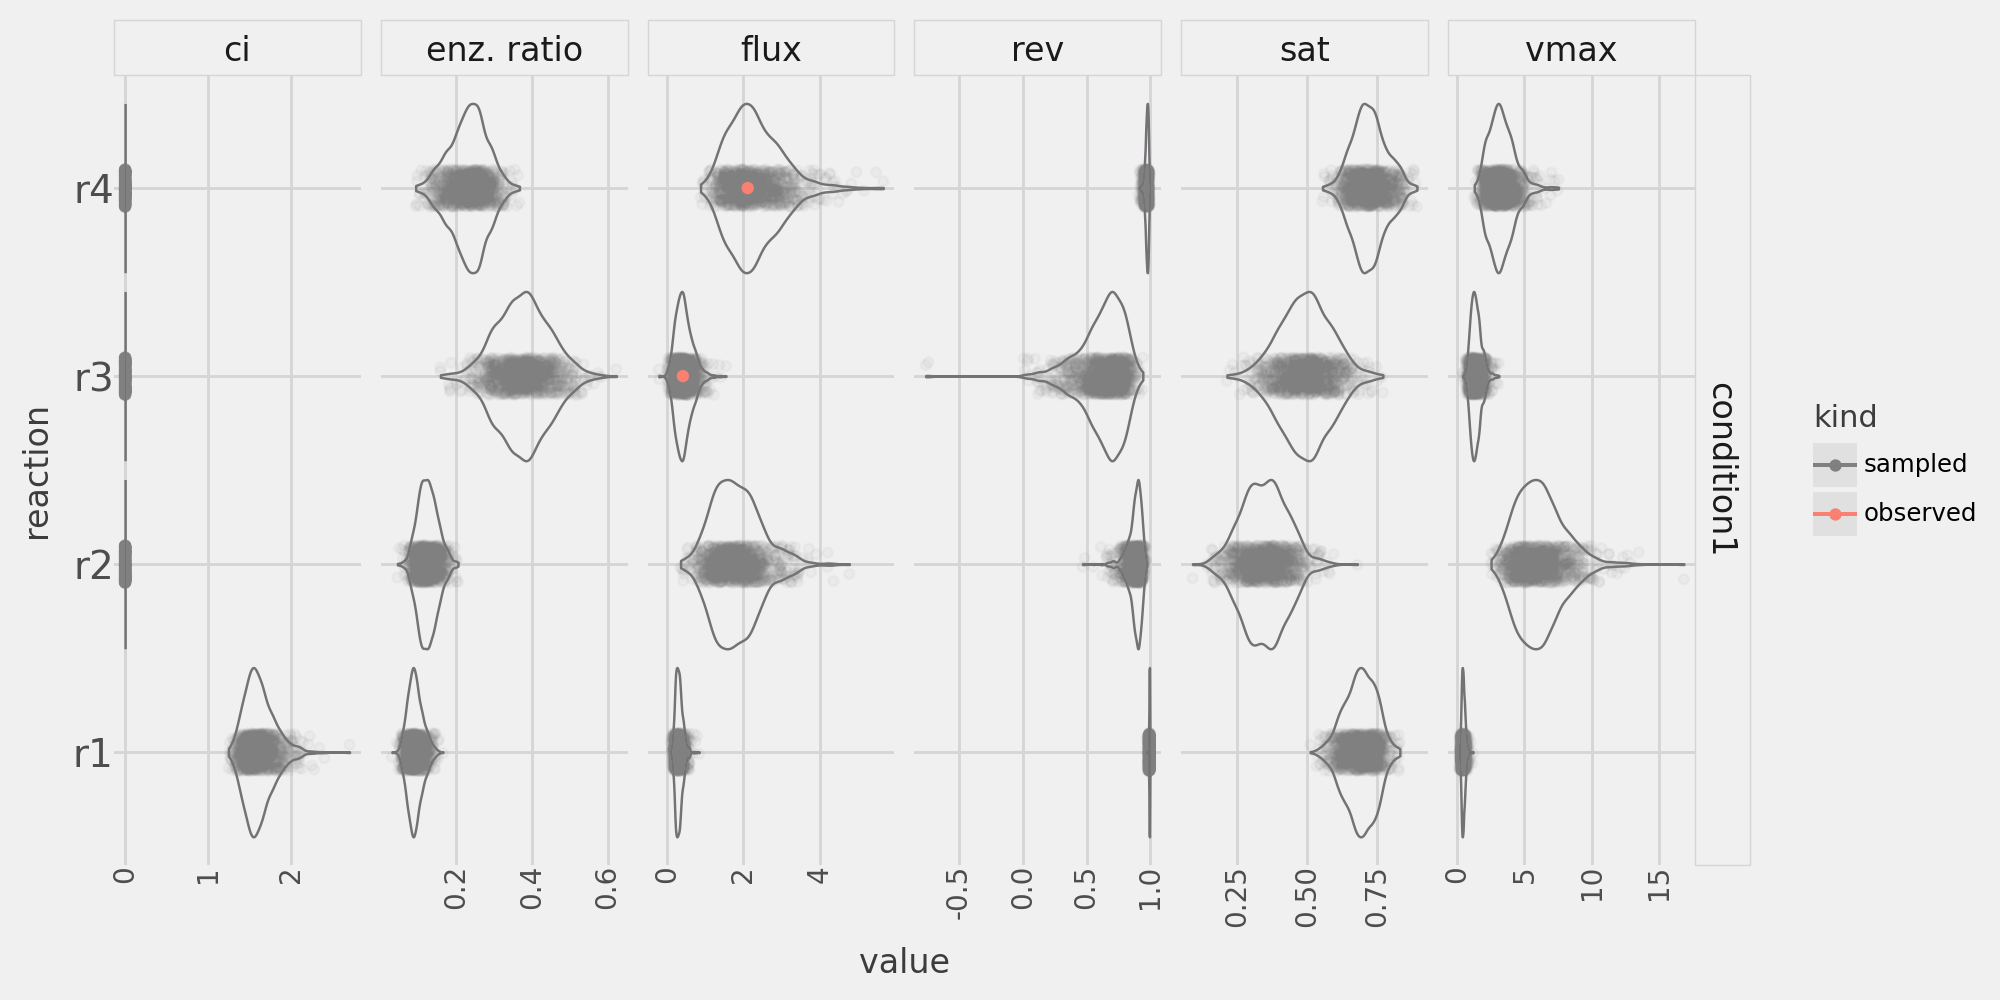

In [48]:
example_ode_flux_plot = (
    ggplot(
        flux_df,
        aes(
            x="reaction",
            y="value",
            color="kind"
        ),
    )
    + geom_violin(scale="width", fill="none", color="#757275")
    + geom_jitter(alpha=0.05, width=0.1, height=0)
    + geom_point(data=reac_meas)
    + geom_linerange(mapping=aes(ymin="down", ymax="up"), data=reac_meas)
    + coord_flip()
    + facet_grid("experiment ~ module", scales="free_x")
    + theme_538()
    #+ theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(figure_size=(10, 5),
           strip_text=element_text(size=12),
        axis_text_y=element_text(size=14),
        axis_text_x=element_text(size=10, rotation=90),
        axis_title=element_text(size=12), strip_background=element_rect(fill="#f0f0f0", color="#d5d5d5", size=0.5, ))
    + scale_color_manual(["gray", "salmon"])
)
example_ode_flux_plot

In [49]:
conc_output = []
for var_name, dfs in across_exps.items():
    if "conc" in var_name:
        for df in dfs:
            df["kind"] = var_name
        conc_output.append(pd.concat(dfs))
conc_df = pd.concat(conc_output)

In [50]:
conc_df = conc_df.melt(id_vars=["experiment", "kind"], var_name="metabolite")

In [51]:
conc_df.loc[conc_df.kind == "ln_bal_conc",  "value"] = np.exp(conc_df.loc[conc_df.kind == "ln_bal_conc", "value"])

In [52]:
maudy.obs_conc

tensor([[0.3231, 3.0219]])

In [53]:
maudy.obs_conc_std

tensor([[0.1000, 0.1000]])

In [54]:
from maud.getting_idatas import MeasurementType

mics_measurements = {
    (exp.id, f"{meas.metabolite}_{meas.compartment}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.MIC
}
conc_meas = [list(keys) + list(val) for keys, val in mics_measurements.items()]
conc_meas = pd.DataFrame(conc_meas, columns=["experiment", "metabolite", "exploc", "scale"])
conc_meas["up"] = np.exp(np.log(conc_meas["exploc"]) + 1.96*conc_meas["scale"])
conc_meas["down"] = np.exp(np.log(conc_meas["exploc"]) - 1.96*conc_meas["scale"])
conc_meas["kind"] = "observed"
conc_meas["value"] = conc_meas["exploc"]

In [55]:
conc_df["kind"] = conc_df["kind"].str.replace("ln_bal_conc", r"$e^{NN}$ balanced loc").str.replace("bal_conc", "[balanced]").str.replace("unb_conc", "[unbalanced]")
conc_meas["kind"] = conc_meas["kind"].str.replace("ln_bal_conc", r"$e^{NN}$ balanced loc").str.replace("bal_conc", "[balanced]").str.replace("unb_conc", "[unbalanced]")

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.


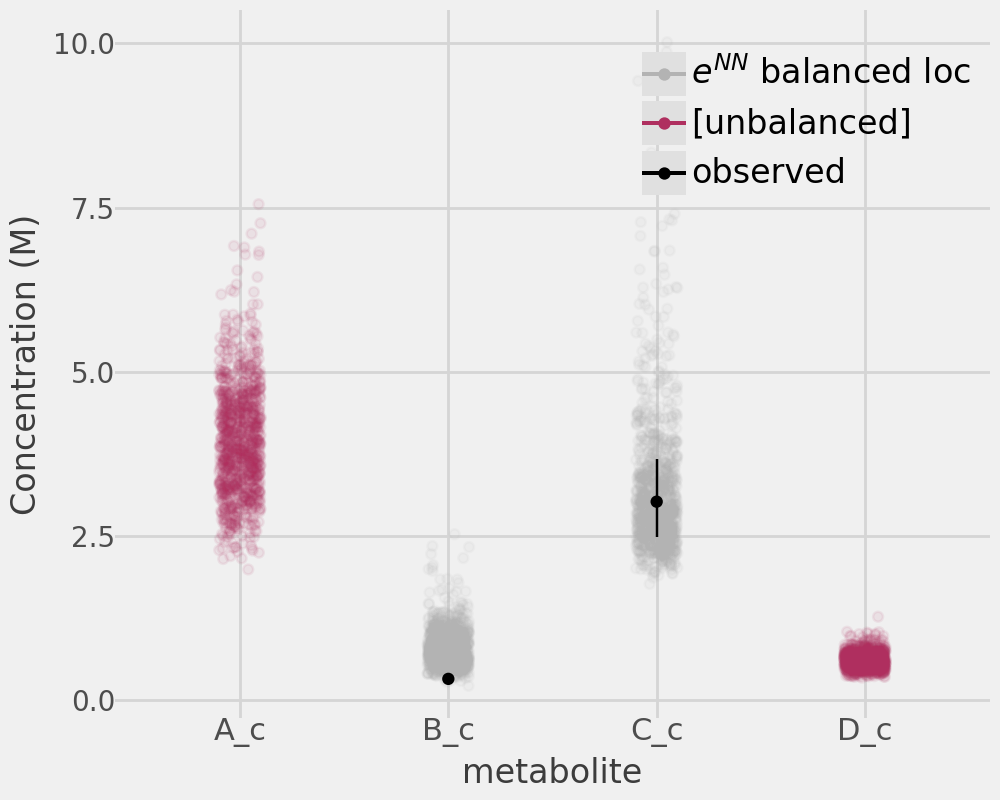

In [56]:
example_ode_plot = (
    ggplot(
        conc_df,
        aes(
            x="metabolite",
            y="value",
            #color="kind",
            color="kind",
        ),
    )
    #+ geom_violin(scale="width")
    + geom_jitter(alpha=0.08, width=0.1, height=0)
    + geom_point(data=conc_meas)
    + geom_linerange(data=conc_meas, mapping=aes(ymin="down", ymax="up"))
    #+ scale_y_log10()
    + theme_538()
    #+ theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(figure_size=(5, 4),
           strip_text=element_text(size=12),
        axis_text_y=element_text(size=10),
            axis_text_x=element_text(size=11, rotation=0),
        legend_position=(0.97,0.93),
        legend_text=element_text(size=12),
        legend_title=element_blank(),
        axis_title=element_text(size=12), strip_background=element_rect(fill="#f0f0f0", color="#d5d5d5", size=0.5, ))
    #+ scale_color_manual(["gray", "red", "black"])
    + scale_color_manual(["#b3b3b3", "#af2f5f",  "black"])
    + ylab("Concentration (M)")
)
example_ode_plot

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.


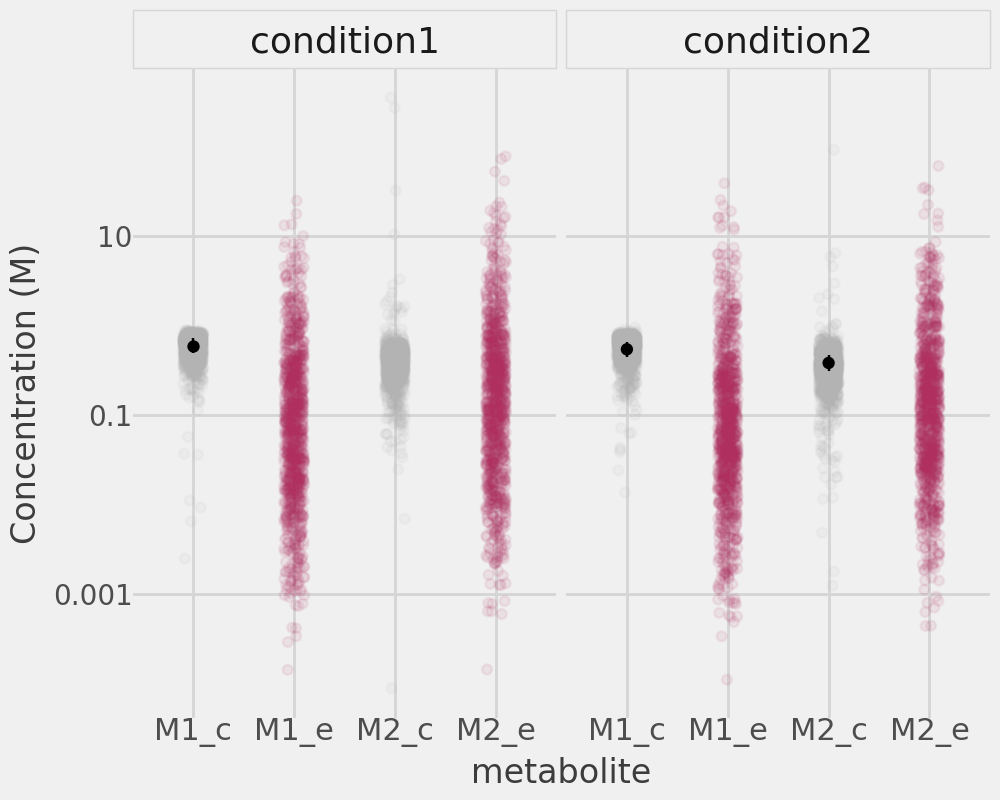

In [57]:
l_conc_plot = linear_plot + theme(figure_size=(5,4), legend_position="none",  strip_text=element_text(size=13), axis_text_x=element_text(size=11, rotation=0), axis_title=element_text(size=12),)
l_conc_plot

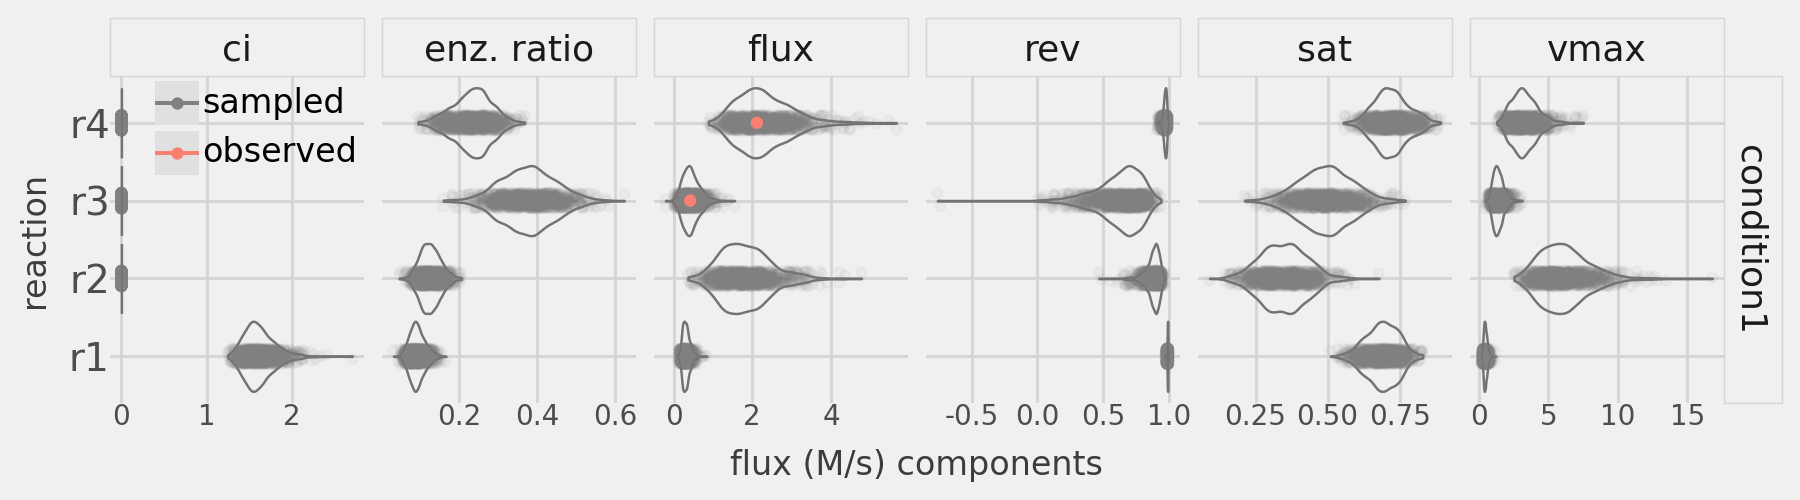

In [58]:
eode_flux_plot = example_ode_flux_plot + theme(figure_size=(9,2.5), legend_title=element_blank(), legend_position=(0.03, 0.99), legend_text=element_text(size=12), axis_text_x=element_text(size=10, rotation=0), axis_title=element_text(size=12), strip_text=element_text(size=13)) + ylab("flux (M/s) components")
eode_flux_plot

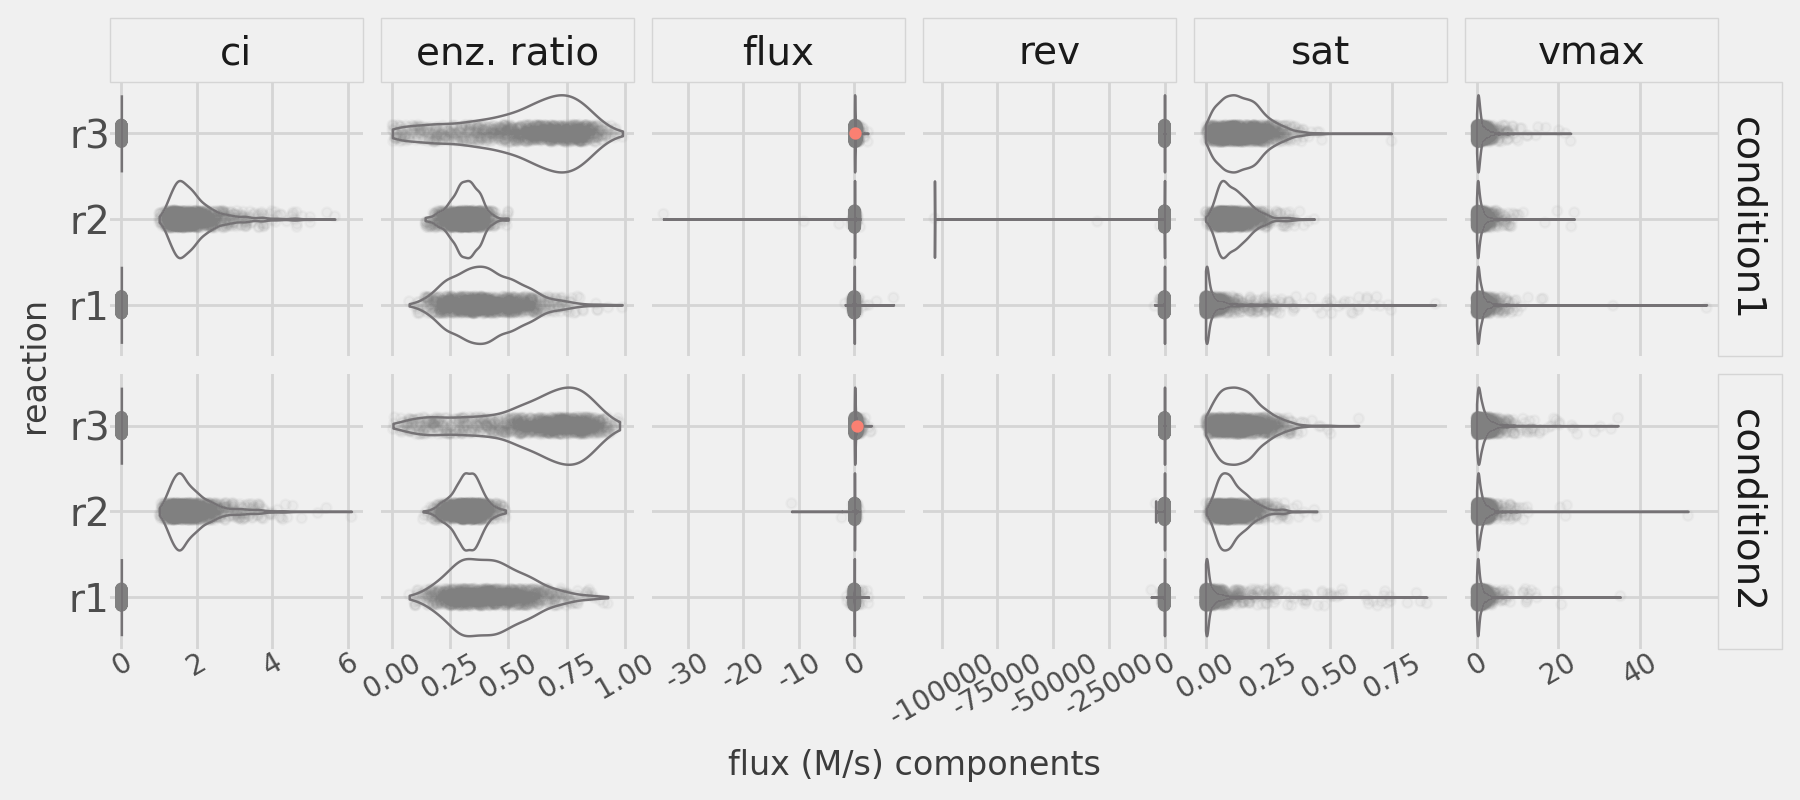

In [59]:
l_flux_plot = linear_flux_plot + theme(figure_size=(9,4), legend_position="none", axis_text_x=element_text(size=10, rotation=30), axis_title=element_text(size=12), strip_text=element_text(size=14)) + ylab("flux (M/s) components")
l_flux_plot

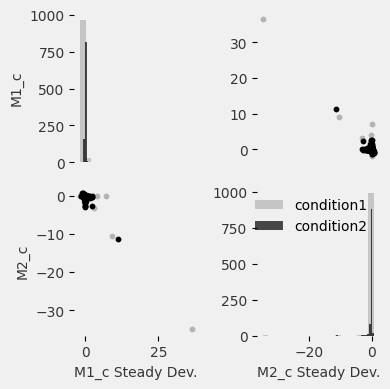

In [60]:
l_ssd_plot

In [61]:
exode_ssd = pairplot(pd.concat(across_exps["ssd"]), (4, 4))

['#75757c']


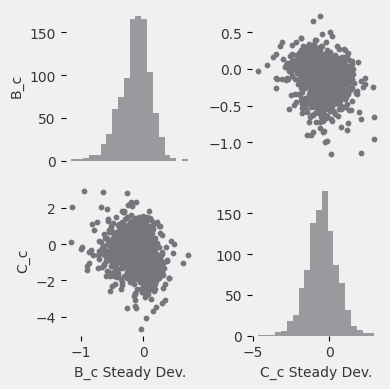

In [62]:
exode_ssd

In [63]:
example_ode_plot.save("eode_plot_actvae.tiff")
eode_flux_plot.save("eode_flux_plot_actvae.tiff")
l_conc_plot.save("l_conc_plot_actvae.tiff")
l_flux_plot.save("l_flux_plot_actvae.tiff")
exode_ssd.savefig("eode_ssd_actvae.tiff")
l_ssd_plot.savefig("l_ssd_plot_actvae.tiff")

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: eode_plot_actvae.tiff
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 4000 rows containing missing values.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 9 x 2.5 in image.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: eode_flux_plot_actvae.tiff
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: l_conc_plot_actvae.tiff
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: Pl